In [4]:
import numpy as np
from matplotlib import pyplot as plt
from enum import Enum
import random

- Mamy planszę 7x7, po której można się poruszać w 4 kierunkach, przy czym ruch w prawo jest o 2 jednostki, chyba że nie jest to możliwe, wtedy tylko o 1. </br></br>
- Każda próba ruchu poza planszę powoduje pozostanie w dotychczasowym miejscu. </br></br>
- Stany końcowe to lewy górny róg i prawy dolny </br></br>
- Każdy ruch powoduje otrzymanie nagrody -1 </br></br>
- Polityka pi jest zawsze deterministyczna, tzn. w ustalonym stanie s, wiemy dokładnie (z p-stwem 1) jaką chcemy wykonać akcję a </br></br>
- Wiemy dokładnie, że wykonanie akcji a w stanie s skończy się nowym, konkrentym, deterministycznym stanem s' </br></br>
- Wiemy też jaka będzie nagroda na każdym przejściu do nowego stanu (zawsze -1) </br></br>

Rozwiązanie będzie metodą *policy iteration*, która jest gorsza niż *value iteration*, ale bardziej zrozumiała. Polega na tym, że do momentu uzyskania optymalnej polityki powtarzane są kroki: ewaluacja polityki pi -> wybranie nowej polityki pi', zachłannej -> ewaluacja...

In [5]:
class Action(Enum):
    N = (-1, 0)
    S = (1, 0)
    E = (0, 2)
    W = (0, -1)

bounds: 0<=i,j<=6, terminal: (0,0), (6,6)

(2,3)-row 2, col 3

In [7]:
def take_action(s, a): # s - state, ex. (3,6), a - action, ex. N
    av = a.value
    if a==Action.E:
        if s[1]+av[1] <= 6:
            return (s[0],s[1]+av[1]) # 2 steps right
        elif s[1]+1 <= 6:
            return (s[0],s[1]+1) # 1 step right
        else: return s
    new_s = (s[0] + av[0], s[1] + av[1])
    if new_s[0] < 0 or new_s[0] > 6 or new_s[1] < 0 or new_s[1] > 6:
        return s  # nothing changes if we're out of bounds
    else: return new_s # new state

In [20]:
r = -1
gamma = 0.9
theta = 0.5 # accuracy of estimating state-value
v = np.zeros([7,7])
# Random starting policy instead of some strict one
policy = [[random.choice(list(Action)) for i in range(7)] for j in range(7)]
policy[0][0] = policy[6][6] = None
stable = False

In [21]:
while(stable == False):
    # Evaluate
    eval_error = float("+Inf")
    while(eval_error > theta):
        eval_error = 0
        for i in range(7):
            for j in range(7):
                if (i,j) == (0,0) or (i,j) == (6,6):
                    continue
                tmp = v[i][j]
                # In state s we know what action to take - a (by policy), what state it will take 
                # us to - s' and what reward we are getting - (-1), so p(s',-1|s,a) = 1
                new_state = take_action((i,j), policy[i][j])
                v[i][j] = -1 + gamma*v[new_state[0], new_state[1]]
                eval_error = max(eval_error, abs(tmp - v[i][j]))
    # Improve policy
    stable = True
    for i in range(7):
        for j in range(7):
            if (i,j) == (0,0) or (i,j) == (6,6):
                    continue
            old_a = policy[i][j]
            max_value = float("-Inf")
            best_action = None
            for a in Action:
                new_state = take_action((i,j), a)
                value = -1 + gamma * v[new_state[0], new_state[1]] # value of the new state, taking action a   
                if value > max_value:
                    max_value = value
                    best_action = a
            policy[i][j] = best_action
            if old_a != policy[i][j]:
                stable = False
      

In [22]:
policy_directions = [[action.name if action else 'None' for action in row] for row in policy]
for row in policy_directions:
    print(row)

['None', 'W', 'W', 'W', 'W', 'W', 'S']
['N', 'N', 'N', 'N', 'N', 'N', 'S']
['N', 'N', 'N', 'N', 'S', 'S', 'S']
['N', 'N', 'N', 'S', 'S', 'S', 'S']
['N', 'N', 'S', 'S', 'S', 'S', 'S']
['S', 'S', 'S', 'S', 'S', 'S', 'S']
['E', 'E', 'E', 'E', 'E', 'E', 'None']


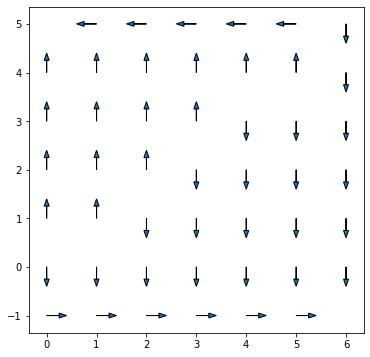

In [23]:
arrows = {"E":(1,0), "W":(-1,0),"N":(0,1),"S":(0,-1)}
scale = 0.25
fig, ax = plt.subplots(figsize=(6, 6))
for r, row in enumerate(policy):
    for c, cell in enumerate(row):
        if cell is None:
            continue
        plt.arrow(c, 5-r, scale*arrows[cell.name][0], scale*arrows[cell.name][1], head_width=0.1)

In [25]:
def print_matrix(matrix):
    for row in matrix:
        print("|", end=" ") 
        for item in row:
            print("{:8}".format(item), end=" ")  
        print("|") 

In [26]:
print_matrix(v)

|      0.0     -1.0     -1.9    -2.71   -3.439  -4.0951 -4.68559 |
|     -1.0     -1.9    -2.71   -3.439  -4.0951 -4.68559  -4.0951 |
|     -1.9    -2.71   -3.439  -4.0951  -4.0951  -4.0951   -3.439 |
|    -2.71   -3.439  -4.0951  -4.0951   -3.439   -3.439    -2.71 |
|   -3.439  -4.0951   -3.439   -3.439    -2.71    -2.71     -1.9 |
|   -3.439   -3.439    -2.71    -2.71     -1.9     -1.9     -1.0 |
|    -2.71    -2.71     -1.9     -1.9     -1.0     -1.0      0.0 |
